In [1]:
import tensorflow as tf
import os
import shutil

path_to_zip = tf.keras.utils.get_file("bike_sharing_dataset.zip", "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip", cache_dir=".", extract=True)
extracted_dir = os.path.splitext(path_to_zip)[0] + "_extracted"
source_csv = os.path.join("datasets", "bike_sharing_dataset_extracted", "hour.csv")
target_csv = os.path.join("datasets", "hour.csv")

os.makedirs("datasets", exist_ok=True)

shutil.copy(source_csv, target_csv)

print(f"Plik hour.csv został skopiowany do {target_csv}")

Plik hour.csv został skopiowany do datasets\hour.csv


In [2]:
import pandas as pd

df = pd.read_csv('datasets/bike_sharing_dataset_extracted/hour.csv')
df['datetime'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str).str.zfill(2), format='%Y-%m-%d %H')

df.set_index('datetime', inplace=True)

print((df.index.min(), df.index.max()))
print((365 + 366) * 24 - len(df))

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 23:00:00'))
165


In [3]:
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
missing = full_index.difference(df.index)
print(missing)
print(df.columns)

DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               ...
               '2012-10-30 07:00:00', '2012-10-30 08:00:00',
               '2012-10-30 09:00:00', '2012-10-30 10:00:00',
               '2012-10-30 11:00:00', '2012-10-30 12:00:00',
               '2012-11-08 03:00:00', '2012-11-29 03:00:00',
               '2012-12-24 04:00:00', '2012-12-25 03:00:00'],
              dtype='datetime64[ns]', length=165, freq=None)
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


C:\Users\User\AppData\Local\Temp\ipykernel_21472\1943020733.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


In [4]:
resampled = pd.DataFrame()
resampled[['holiday', 'weekday', 'workingday', 'weathersit']] = df.resample(rule='1h').ffill()[['holiday', 'weekday', 'workingday', 'weathersit']]
resampled[['temp', 'atemp', 'hum', 'windspeed']] = df.resample(rule='1h').interpolate(method="linear")[['temp', 'atemp', 'hum', 'windspeed']]
resampled[['casual', 'registered', 'cnt']] = df.resample(rule='1h').asfreq(0)[['casual', 'registered', 'cnt']]
# print(df.loc["2011-01-02 00:00:00":"2011-01-02 10:00:00"])
print(resampled.loc["2011-01-02 03:00:00":"2011-01-02 7:00:00"])

                     holiday  weekday  workingday  weathersit  temp    atemp  \
datetime                                                                       
2011-01-02 03:00:00        0        0           0           2  0.46  0.45450   
2011-01-02 04:00:00        0        0           0           2  0.46  0.45450   
2011-01-02 05:00:00        0        0           0           2  0.44  0.43935   
2011-01-02 06:00:00        0        0           0           3  0.42  0.42420   
2011-01-02 07:00:00        0        0           0           2  0.40  0.40910   

                       hum  windspeed  casual  registered  cnt  
datetime                                                        
2011-01-02 03:00:00  0.940    0.19400       2           4    6  
2011-01-02 04:00:00  0.940    0.19400       2           1    3  
2011-01-02 05:00:00  0.855    0.24625       0           0    0  
2011-01-02 06:00:00  0.770    0.29850       0           2    2  
2011-01-02 07:00:00  0.760    0.19400       0    

C:\Users\User\AppData\Local\Temp\ipykernel_21472\78260645.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  resampled[['temp', 'atemp', 'hum', 'windspeed']] = df.resample(rule='1h').interpolate(method="linear")[['temp', 'atemp', 'hum', 'windspeed']]


In [5]:
df = resampled
df.notna().sum()

holiday       17544
weekday       17544
workingday    17544
weathersit    17544
temp          17544
atemp         17544
hum           17544
windspeed     17544
casual        17544
registered    17544
cnt           17544
dtype: int64

<Axes: xlabel='datetime'>

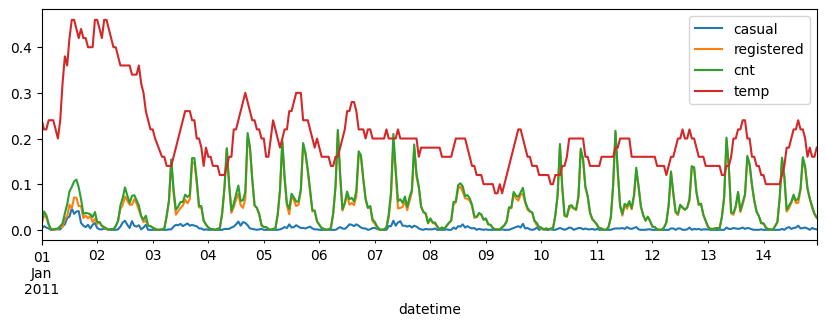

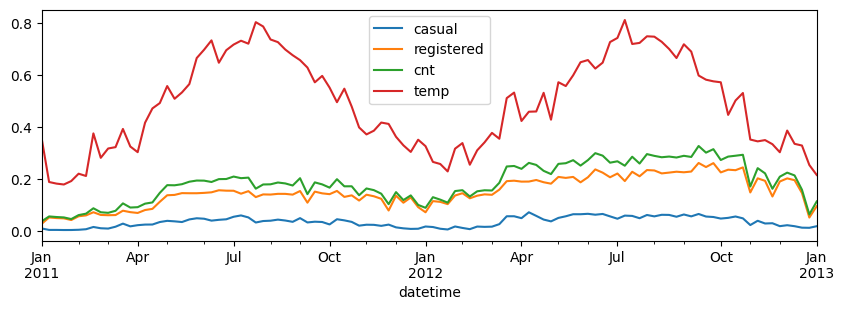

In [6]:
df[['casual', 'registered', 'cnt', 'weathersit']].describe()

df.casual /= 1e3
df.registered /= 1e3
df.cnt /= 1e3
df.weathersit /= 4

df_2weeks = df[:24 * 7 * 2]
df_2weeks[['casual', 'registered', 'cnt', 'temp']].plot(figsize=(10, 3))

df_daily = df.resample('W').mean()
df_daily[['casual', 'registered', 'cnt', 'temp']].plot(figsize=(10, 3))

In [7]:
import numpy as np
import pickle

df['cnt_scaled'] = df['cnt'] * 10**3

cnt_pred_day = df['cnt_scaled'].shift(24)
mae_daily = np.mean(np.abs(df['cnt_scaled'] - cnt_pred_day))

cnt_pred_week = df['cnt_scaled'].shift(24 * 7)
mae_weekly = np.mean(np.abs(df['cnt_scaled'] - cnt_pred_week))

mae_daily = round(mae_daily, 2)
mae_weekly = round(mae_weekly, 2)

with open("mae_baseline.pkl", "wb") as f:
    pickle.dump((mae_daily, mae_weekly), f)

print(f"MAE daily: {mae_daily}, MAE weekly: {mae_weekly}")

MAE daily: 63.79, MAE weekly: 52.43


In [8]:
cnt_train = df['cnt']['2011-01-01 00:00':'2012-06-30 23:00']
cnt_valid = df['cnt']['2012-07-01 00:00':]

seq_len = 1 * 24
train_ds = tf.keras.utils.timeseries_dataset_from_array(
            cnt_train.to_numpy(),
            targets=cnt_train[seq_len:],
            sequence_length=seq_len,
            batch_size=32,
            shuffle=True,
            seed=42
            )

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
            cnt_valid.to_numpy(),
            targets=cnt_valid[seq_len:],
            sequence_length=seq_len,
            batch_size=32
            )

In [ ]:
import keras 

def build_model(learning_rate):
    model = tf.keras.Sequential([tf.keras.Input(shape=(seq_len,)), tf.keras.layers.Dense(1)])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9), loss=keras.losses.Huber(), metrics=['mae'])
    return model

def build_model_LSTM(learning_rate):
    model = tf.keras.Sequential([tf.keras.Input(shape=[None, 1]), tf.keras.layers.LSTM(1)])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9), loss=keras.losses.Huber(), metrics=['mae'])
    return model

def build_model_RNN(learning_rate):
    model = tf.keras.Sequential([tf.keras.Input(shape=[None, 1]), tf.keras.layers.LSTM(32), tf.keras.layers.Dense(1)])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9), loss=keras.losses.Huber(), metrics=['mae'])
    return model

def build_model_DEEP_RNN(learning_rate):
    model = tf.keras.Sequential([tf.keras.Input(shape=[None, 1])])
    model.add(tf.keras.layers.LSTM(32, return_sequences=True))
    model.add(tf.keras.layers.LSTM(32, return_sequences=True))
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9), loss=keras.losses.Huber(), metrics=['mae'])
    return model

In [11]:
models = {
    "linear"  : build_model,
    "rnn1"    : build_model_LSTM,
    "rnn32"   : build_model_RNN,
    "rnn_deep": build_model_DEEP_RNN
}

for name in models.keys():
    lr = 0.1
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    model = models[name](lr)
    model.fit(train_ds, epochs=20, validation_data=valid_ds, verbose=0, callbacks=[lr_schedule])
    mea_linear = model.evaluate(valid_ds)[1]
    model.save(f'model_{name}.keras')

    with open(f"mae_{name}.pkl", "wb") as file:
        pickle.dump((mea_linear * 10**3, ), file)

KeyboardInterrupt: 

In [26]:
cnt_train = df[['cnt', 'workingday', 'weathersit', 'atemp']]['2011-01-01 00:00':'2012-06-30 23:00']
cnt_valid = df[['cnt', 'workingday', 'weathersit', 'atemp']]['2012-07-01 00:00':]

seq_len = 1 * 24
train_ds = tf.keras.utils.timeseries_dataset_from_array(
            cnt_train.to_numpy(),
            targets=cnt_train[seq_len:],
            sequence_length=seq_len,
            batch_size=32,
            shuffle=True,
            seed=42
            )

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
            cnt_valid.to_numpy(),
            targets=cnt_valid[seq_len:],
            sequence_length=seq_len,
            batch_size=32
            )

In [27]:
import keras 

def build_model_deep_rnn_multi(learning_rate):
    model = tf.keras.Sequential([tf.keras.Input(shape=[None, 4])])
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9), loss=keras.losses.Huber(), metrics=['mae'])
    return model

lr = 0.1
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

model = build_model_deep_rnn_multi(lr)
model.fit(train_ds, epochs=20, validation_data=valid_ds, verbose=0, callbacks=[lr_schedule])
mae = model.evaluate(valid_ds)[1]

model.save('model_rnn_mv.keras')

with open("mae_rnn_mv.pkl", "wb") as file:
    pickle.dump((mae * 10 **3, ), file)


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.030000000447034835.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.009000000357627868.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.002700000163167715.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0008100000210106373.
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - mae: 0.2592
